### Library Import

In [1]:
import os
from typing import List, Dict
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML

### Data Load

In [2]:
# 파일 호출
data_path: str = "../data/raw"
train_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "train.csv")).assign(_type="train") # train 에는 _type = train
test_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv")).assign(_type="test") # test 에는 _type = test
df: pd.DataFrame = pd.concat([train_df, test_df], axis=0)

In [3]:
# HOURLY_ 로 시작하는 .csv 파일 이름을 file_names 에 할딩
file_names: List[str] = [
    f for f in os.listdir(data_path) if f.startswith("HOURLY_") and f.endswith(".csv")
]

# 파일명 : 데이터프레임으로 딕셔너리 형태로 저장
file_dict: Dict[str, pd.DataFrame] = {
    f.replace(".csv", ""): pd.read_csv(os.path.join(data_path, f)) for f in file_names
}

for _file_name, _df in tqdm(file_dict.items()):
    # 열 이름 중복 방지를 위해 {_file_name.lower()}_{col.lower()}로 변경, datetime 열을 ID로 변경
    _rename_rule = {
        col: f"{_file_name.lower()}_{col.lower()}" if col != "datetime" else "ID"
        for col in _df.columns
    }
    _df = _df.rename(_rename_rule, axis=1)
    df = df.merge(_df, on="ID", how="left")


100%|██████████| 107/107 [00:01<00:00, 89.82it/s]


### 거래소별 EDA

거래소 간 지표들의 차이들이 유효한지 확인하기 위한 기본적인 EDA를 진행합니다. 여기서는 거래소가 여러개이기 때문에 renaming을 진행하지 않고 raw name으로 진행하겠습니다. target은 _type이 train인 항목에만 존재하기 때문에 train_df에 별도로 할당해 진행하겠습니다.

In [4]:
train_df = df.loc[df["_type"]=="train"]

In [5]:
train_df.shape

(8760, 255)

기본적인 지표로 활용될 수 있는 피쳐의 개수는 30여개인데 반해 train_df에 있는 column 의 개수는 200개가 넘습니다. target별 거래소간 차이가 유의미하다면 모델에 들어가야 되지만 유의미하지 않다면 필요없는 피쳐를 많이 줄일 수 있습니다. 거래소별 data가 있는 칼럼으로는 **Funding-rates**, **Liquidations(Long and Short)**, **Open-interest**, **Taker-Buy-Sell-Stats**가 있습니다.

#### Funding rates

column들이 많기 때문에 scroll 세팅부터 설정하고 진행합니다

In [6]:
# 긴 DataFrame을 스크롤 가능한 형태로 출력하는 함수
def display_scrollable_dataframe(df, max_height=300):
    display(HTML(f"""
    <div style="max-height: {max_height}px; overflow-y: scroll;">
        {df.to_html()}
    </div>
    """))

In [7]:
def display_scrollable_list(list_items, max_height=300):
    # 리스트를 HTML 형식으로 변환하여 출력
    display(HTML(f"""
    <div style="max-height: {max_height}px; overflow-y: scroll; border:1px solid black; padding: 10px;">
        <pre>{list_items}</pre>
    </div>
    """))


In [8]:
funding_columns = [col for col in train_df.columns if 'funding' in col]
display_scrollable_list("\n".join(funding_columns), max_height=150)

In [9]:
# 거래소와 target별로 funding rates의 통계량 (평균, 중앙값, 표준편차 등) 계산
stats = train_df.groupby(['target'])[funding_columns].agg(['mean', 'median', 'std', 'min', 'max', 'count']).reset_index()

# 통계량 확인
display_scrollable_dataframe(stats, max_height=200)


All exchanges 와 다른 거래소 funding rates를 비교했을 때 통계량에서, 특히나 mean과 standard deviation에서 큰 차이가 없음을 확인할 수 있습니다. 따라서 funding rates 의 경우, all exchanges 하나만 피쳐에 넣는 것과 모든 거래소의 funding rates를 넣는 것이 큰 차이가 없음을 확인할 수 있습니다.

/var/folders/7y/bqhzt9sn3zn65pztbxqsqbzm0000gn/T/ipykernel_71147/3639784354.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=corr_df, x='funding_rate', y='spearman_corr', palette='Blues')


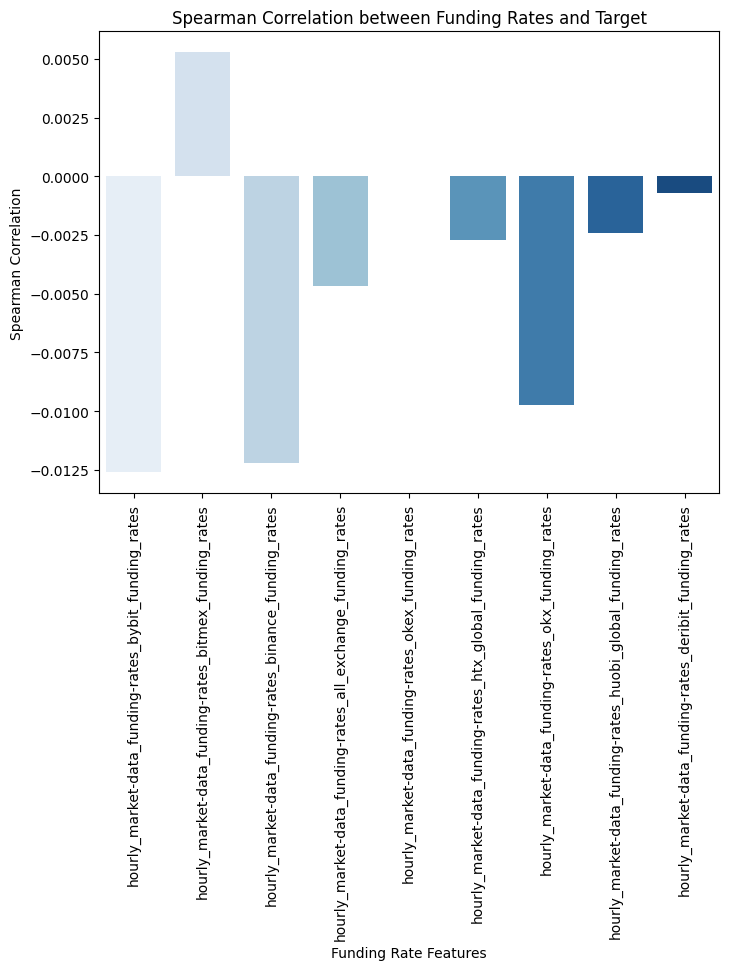

In [10]:
# Spearman 상관계수 계산
correlations = {}

for col in funding_columns:
    # spearman 상관계수 계산 (target 과 funding_rates)
    correlation = train_df[[col, 'target']].corr(method='spearman').iloc[0, 1]
    correlations[col] = correlation

# 상관계수를 DataFrame으로 변환
corr_df = pd.DataFrame(list(correlations.items()), columns=['funding_rate', 'spearman_corr'])

# 상관계수 시각화
plt.figure(figsize=(8, 6))
sns.barplot(data=corr_df, x='funding_rate', y='spearman_corr', palette='Blues')


plt.xticks(rotation=90)
plt.title('Spearman Correlation between Funding Rates and Target')
plt.ylabel('Spearman Correlation')
plt.xlabel('Funding Rate Features')


# 시각화 출력
plt.show()

위의 상관계수 차트를 확인해도 모든 거래소의 funding rates를 넣어 유의미한 결과를 얻을 수 없다는 결론을 낼 수 있습니다.

#### Liquidations

##### Long Liquidations

In [11]:
column = [col for col in train_df.columns if 'long_liquidation' in col]
display_scrollable_list("\n".join(column), max_height=150)

위의 결과에서 확인할 수 있듯이 long liquidations 같은 경우 usd가 포함되어 굉장히 많은 컬럼들이 추가 됩니다. usd 같은 경우 지표를 환율로 나타낸 수치기에 usd가 붙어 있지 않은 column과 correlation이 굉장히 높기 때문에 EDA에서는 제외하겠습니다.

In [13]:
long_liquidation_columns = [col for col in train_df.columns if col.endswith('long_liquidations')]
display_scrollable_list("\n".join(long_liquidation_columns), max_height=150)

In [16]:
# target별로 long liquidations 통계량 (평균, 중앙값, 표준편차 등) 계산
stats = train_df.groupby('target')[long_liquidation_columns].agg(['mean', 'median', 'std', 'min', 'max', 'count']).reset_index()

# 통계량 출력
display_scrollable_dataframe(stats, max_height=200)


long liquidations 관련 칼럼들은 수가 많은 만큼 okex와 ftx에서 NaN값이 발견됨을 확인할 수 있으며 여전히 all_exchange와 다를 바 없이 0과3 에서 평균 수치가 높고 standard deviation 값이 높으며 1과 2에서 평균 수치가 낮고 standard deviation 값이 낮음을 알 수 있습니다.

In [17]:
# 각 컬럼에 대해 Spearman 상관계수 계산
correlations = {}

for col in long_liquidation_columns:
    # Spearman 상관계수 계산
    correlation = train_df[[col, 'target']].corr(method='spearman').iloc[0, 1]
    correlations[col] = correlation

# 결과를 DataFrame으로 변환
corr_df = pd.DataFrame(list(correlations.items()), columns=['long_liquidations', 'spearman_corr'])

# 상관계수 출력
display_scrollable_dataframe(corr_df, max_height=200)

,long_liquidations,spearman_corr
0,hourly_market-data_liquidations_gate_io_all_symbol_long_liquidations,0.042310
1,hourly_market-data_liquidations_htx_global_all_symbol_long_liquidations,0.028053
2,hourly_market-data_liquidations_binance_btc_usdt_long_liquidations,0.051815
3,hourly_market-data_liquidations_bitmex_btc_usd_long_liquidations,0.036355
4,hourly_market-data_liquidations_gate_io_btc_usd_long_liquidations,0.039487
5,hourly_market-data_liquidations_okex_btc_usd_long_liquidations,NaN
6,hourly_market-data_liquidations_bybit_btc_usd_long_liquidations,0.035287
7,hourly_market-data_liquidations_okex_btc_usdt_long_liquidations,NaN
8,hourly_market-data_liquidations_okex_all_symbol_long_liquidations,NaN
9,hourly_market-data_liquidations_huobi_global_all_symbol_long_liquidations,0.027852


칼럼의 개수가 많아 시각화보다는 target 값과의 correlation 값을 직접적으로 나타낸게 위의 수치입니다. 5번 all exchange와 다른 거래소들을 비교하면 특출나게 높은 거래소가 없음을 확인할 수 있습니다.

##### Short liquidations

In [18]:
short_liquidation_columns = [col for col in train_df.columns if col.endswith('short_liquidations')]
display_scrollable_list("\n".join(short_liquidation_columns), max_height=150)

In [20]:
# target별로 short liquidations 통계량 (평균, 중앙값, 표준편차 등) 계산
stats = train_df.groupby('target')[short_liquidation_columns].agg(['mean', 'median', 'std', 'min', 'max', 'count']).reset_index()

# 통계량 출력
display_scrollable_dataframe(stats)


short liquidations도 long liquidations 와 같이 target 별 통계량 상 거래소들과 all exchange의 추이가 유의미한 차이가 없음을 알 수 있습니다. 0과 3 에서 mean 과 standard deviation이 높고 1과 2에서 mean과 standard deviation이 낮음을 알 수 있습니다.

In [21]:
# 각 컬럼에 대해 Spearman 상관계수 계산
correlations = {}

for col in short_liquidation_columns:
    # Spearman 상관계수 계산
    correlation = train_df[[col, 'target']].corr(method = 'spearman').iloc[0, 1]
    correlations[col] = correlation

# 결과를 DataFrame으로 변환
corr_df = pd.DataFrame(list(correlations.items()), columns=['short_liquidations', 'spearman_corr'])

# 상관계수 출력
display_scrollable_dataframe(corr_df, max_height=150)


,short_liquidations,spearman_corr
0,hourly_market-data_liquidations_gate_io_all_symbol_short_liquidations,-0.024140
1,hourly_market-data_liquidations_htx_global_all_symbol_short_liquidations,-0.019216
2,hourly_market-data_liquidations_binance_btc_usdt_short_liquidations,-0.009087
3,hourly_market-data_liquidations_bitmex_btc_usd_short_liquidations,-0.015187
4,hourly_market-data_liquidations_gate_io_btc_usd_short_liquidations,-0.023343
5,hourly_market-data_liquidations_okex_btc_usd_short_liquidations,NaN
6,hourly_market-data_liquidations_bybit_btc_usd_short_liquidations,-0.024119
7,hourly_market-data_liquidations_okex_btc_usdt_short_liquidations,NaN
8,hourly_market-data_liquidations_okex_all_symbol_short_liquidations,NaN
9,hourly_market-data_liquidations_huobi_global_all_symbol_short_liquidations,-0.019423


correlation 수치도 큰 차이가 없음을 위에서 확인할 수 있습니다

#### Open interest

In [22]:
open_interest_columns = [col for col in train_df.columns if 'open_interest' in col]
display_scrollable_list("\n".join(open_interest_columns), max_height=200)

In [23]:
# target별로 open interest 통계량 (평균, 중앙값, 표준편차 등) 계산
stats = train_df.groupby('target')[open_interest_columns].agg(['mean', 'median', 'std', 'min', 'max', 'count']).reset_index()

# 통계량을 scrollable하게 출력
display_scrollable_dataframe(stats, max_height=200)

open interest 또한 all_exchange 대신에 거래소 데이타 각각 column으로 쓸 이유가 없어 보입니다. 거기에 통계량 상으로 target값 별 유의미한 통계량 차이가 없어 보이는 것과 값이 다른 지표에 비해 굉장히 큰 게 특징으로 볼 수 있습니다.

In [24]:
# 각 컬럼에 대해 Spearman 상관계수 계산
correlations = {}

for col in open_interest_columns:
    # Spearman 상관계수 계산
    correlation = train_df[[col, 'target']].corr(method='spearman').iloc[0, 1]
    correlations[col] = correlation

# 결과를 DataFrame으로 변환
corr_df = pd.DataFrame(list(correlations.items()), columns=['open_interest', 'spearman_corr'])

# 상관계수 출력
display_scrollable_dataframe(corr_df, max_height=200)


,open_interest,spearman_corr
0,hourly_market-data_open-interest_ftx_btc_usd_open_interest,NaN
1,hourly_market-data_open-interest_bybit_open_interest,NaN
2,hourly_market-data_open-interest_binance_btc_busd_open_interest,-0.010485
3,hourly_market-data_open-interest_kraken_open_interest,NaN
4,hourly_market-data_open-interest_okx_open_interest,NaN
5,hourly_market-data_open-interest_deribit_open_interest,NaN
6,hourly_market-data_open-interest_deribit_btc_usd_open_interest,0.002106
7,hourly_market-data_open-interest_bitfinex_open_interest,NaN
8,hourly_market-data_open-interest_huobi_global_btc_usd_open_interest,-0.005615
9,hourly_market-data_open-interest_htx_global_all_symbol_open_interest,-0.013123


correlation 값도 통계량 분석으로부터 나온 결론을 뒤집기에 부족해 보입니다

#### Buy-Sell 지표

##### Buy 지표

In [25]:
taker_buy_columns = [col for col in train_df.columns if 'taker_buy' in col]
display_scrollable_list("\n".join(taker_buy_columns), max_height=200)

In [26]:
# target별로 taker buy 통계량 (평균, 중앙값, 표준편차 등) 계산
stats = train_df.groupby('target')[taker_buy_columns].agg(['mean', 'median', 'std', 'min', 'max', 'count']).reset_index()

# 통계량을 scrollable하게 출력
display_scrollable_dataframe(stats, max_height=200)


taker buy랑 관련된 칼럼들에 대한 target 별 통계량에서도 all exchange 대신에 다른 거래소도 피쳐에 포함하기에는 유의미한 차이가 보이지 않습니다. 특이사항으로는 buy volume 이 0과 3 에서 mean이 높고 1과 2 에서 낮음을 확인할 수 있습니다.

In [27]:
# 각 컬럼에 대해 Spearman 상관계수 계산
correlations = {}

for col in taker_buy_columns:
    # Spearman 상관계수 계산
    correlation = train_df[[col, 'target']].corr(method='spearman').iloc[0, 1]
    correlations[col] = correlation

# 결과를 DataFrame으로 변환
corr_df = pd.DataFrame(list(correlations.items()), columns=['taker_buy_columns', 'spearman_corr'])

# 상관계수 출력
display_scrollable_dataframe(corr_df, max_height=150)

,taker_buy_columns,spearman_corr
0,hourly_market-data_taker-buy-sell-stats_deribit_taker_buy_volume,0.011155
1,hourly_market-data_taker-buy-sell-stats_deribit_taker_buy_ratio,-0.024293
2,hourly_market-data_taker-buy-sell-stats_deribit_taker_buy_sell_ratio,-0.023977
3,hourly_market-data_taker-buy-sell-stats_bybit_taker_buy_volume,0.004921
4,hourly_market-data_taker-buy-sell-stats_bybit_taker_buy_ratio,-0.030792
5,hourly_market-data_taker-buy-sell-stats_bybit_taker_buy_sell_ratio,-0.030792
6,hourly_market-data_taker-buy-sell-stats_htx_global_taker_buy_volume,0.016646
7,hourly_market-data_taker-buy-sell-stats_htx_global_taker_buy_ratio,-0.024592
8,hourly_market-data_taker-buy-sell-stats_htx_global_taker_buy_sell_ratio,-0.024143
9,hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_volume,0.003445


correlation 에서도 통계량 분석과 동일한 패턴을 보임을 위의 결과로 확인 할 수 있습니다

##### Sell 지표

In [28]:
taker_sell_columns = [col for col in train_df.columns if 'taker_sell' in col]
display_scrollable_list("\n".join(taker_sell_columns), max_height=150)

In [29]:
# target별로 taker sell 통계량 (평균, 중앙값, 표준편차 등) 계산
stats = train_df.groupby('target')[taker_sell_columns].agg(['mean', 'median', 'std', 'min', 'max', 'count']).reset_index()

# 통계량을 scrollable하게 출력
display_scrollable_dataframe(stats, max_height=200)


위는 target 별 sell volume과 sell ratio 거래소별 통계량 테이블입니다. 여전히 거래소별 피쳐를 넣기에는 설득력 있는 결과가 없으며 상기할 만한 점으로는 0과 3 에서 sell volume mean 이 높고 1과 2에서 mean이 낮음을 확인할 수 있습니다.

In [30]:
# 각 컬럼에 대해 Spearman 상관계수 계산
correlations = {}

for col in taker_sell_columns:
    # Spearman 상관계수 계산
    correlation = train_df[[col, 'target']].corr(method='spearman').iloc[0, 1]
    correlations[col] = correlation

# 결과를 DataFrame으로 변환
corr_df = pd.DataFrame(list(correlations.items()), columns=['taker_sell_columns', 'spearman_corr'])

# 상관계수 출력
display_scrollable_dataframe(corr_df, max_height=150)

,taker_sell_columns,spearman_corr
0,hourly_market-data_taker-buy-sell-stats_deribit_taker_sell_volume,0.019242
1,hourly_market-data_taker-buy-sell-stats_deribit_taker_sell_ratio,0.024293
2,hourly_market-data_taker-buy-sell-stats_bybit_taker_sell_volume,0.020770
3,hourly_market-data_taker-buy-sell-stats_bybit_taker_sell_ratio,0.031880
4,hourly_market-data_taker-buy-sell-stats_htx_global_taker_sell_volume,0.028693
5,hourly_market-data_taker-buy-sell-stats_htx_global_taker_sell_ratio,0.024299
6,hourly_market-data_taker-buy-sell-stats_all_exchange_taker_sell_volume,0.016715
7,hourly_market-data_taker-buy-sell-stats_all_exchange_taker_sell_ratio,0.060934
8,hourly_market-data_taker-buy-sell-stats_okx_taker_sell_volume,0.022858
9,hourly_market-data_taker-buy-sell-stats_okx_taker_sell_ratio,0.036159


**거래소별 EDA 결론**:  

- 거래소별 지표가 all exchanges와 비교했을 때 유의미하지 않아 거래소별 피쳐가 존재할 때 all_exchanges 하나만 분석함이 용이해 보입니다.

- 0과 3, 1과 2가 통계량 상 묶이는 경향이 있고 기본적으로 multiclass 문제로 생각할 수 있겠지만 1시간 뒤 비트코인 값이 오를지 내릴 지 구분하는 binary classification 문제로 먼저 해결하고 그 다음 단계를 밟는 문제로 바꿀 수 있습니다. 그러나, 지금까지 확인했듯이 0과 3, 1과 2가 통계량이 굉장히 흡사한 경우가 많았고 따라서 0이 내려감, 1이 올라감으로 binary classification 문제를 정의할 때에도 거래소별 차이가 유의미한 결과가 나타나지 않을 수 있음을 예상해 볼 수 있습니다.

- 따라서, 이후 진행하는 EDA에서는 현재의 데이타 프레임에서 거래소별 지표는 drop 시키고 진행하겠습니다.